In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nashpy as nash
import itertools
import cvxpy as cp
import cvxopt
from tqdm import tqdm
import seaborn as sb
from scipy.stats import skewnorm
from scipy.optimize import minimize
import pickle

In [39]:
# Fill in missing based on elo ratings
def win_rate_elo(elo1, elo2, alpha = np.log(10)/400):
    """
    Computes win rate of player 1 to player 2 given their elo ratings
    """
    return 1 / (1 + np.exp(-alpha * (elo1 - elo2)))

In [40]:
df = pd.read_csv('Data/FICS/2019/2019_All.csv')
df = df.iloc[:, 2:]
df

,White,Black,WhiteElo,BlackElo,Result
0,ytunde,janok,1682,1545,1-0
1,bijsah,Babuya,1243,1259,0-1
2,anjii,MisterMustard,1465,1574,0-1
3,wycliff,KECHMATE,1518,1713,0-1
4,centrozap,sirschaap,1652,1575,0-1
...,...,...,...,...,...
1439995,mcSol_aar,ebi1553,1803,1814,1/2-1/2
1439996,catgotyourtongue,EZZELDEEN,1867,1462,1-0
1439997,n3b4,lukasi96,1286,1257,0-1
1439998,adekcz,AlpAlp54,1912,1704,1-0


In [41]:
df = df.rename(columns = {'White': 'white_player', 'Black': 'black_player', 'Result':'result',
                         'WhiteElo': 'white_elo', 'BlackElo':'black_elo'})
df.head()

,white_player,black_player,white_elo,black_elo,result
0,ytunde,janok,1682,1545,1-0
1,bijsah,Babuya,1243,1259,0-1
2,anjii,MisterMustard,1465,1574,0-1
3,wycliff,KECHMATE,1518,1713,0-1
4,centrozap,sirschaap,1652,1575,0-1


In [42]:
df[df['result'] == '*']

,white_player,black_player,white_elo,black_elo,result
1218184,cheddarman1,acoola,1910,1895,*
1218242,BearBully,vj1,2378,2040,*
1231776,cubanrussian,z52,1823,1867,*
1236724,newsimbol,juldar,1590,1552,*
1239041,zarpullido,jacdav,1975,1955,*
1267419,centralito78,sanketc,1360,1248,*
1268225,vebvass,Trawmio,1179,1189,*
1279372,moulin,cmays90,1596,1442,*
1280245,giowlad,Vamostodorecto,2015,1815,*
1281237,Vladkur,Sinned298,2461,2367,*


In [43]:
possible_results = ['0-1', '1-0', '1/2-1/2']
drop_idx = df[~df['result'].isin(possible_results)].index
df = df.drop(drop_idx)

df[df['result'] == '*']

,white_player,black_player,white_elo,black_elo,result


In [44]:
df.loc[df['result'] == '0-1', 'result'] = -1
df.loc[df['result'] == '1-0', 'result'] = 1
df.loc[df['result'] == '1/2-1/2', 'result'] = 0

In [45]:
white_elos = np.array(df['white_elo'])
black_elos = np.array(df['black_elo'])

(array([3.03000e+02, 1.50280e+04, 2.25370e+05, 6.43281e+05, 4.38660e+05,
        1.03538e+05, 9.58300e+03, 3.04200e+03, 9.57000e+02, 1.83000e+02]),
 array([ 447. ,  752.3, 1057.6, 1362.9, 1668.2, 1973.5, 2278.8, 2584.1,
        2889.4, 3194.7, 3500. ]),
 <BarContainer object of 10 artists>)

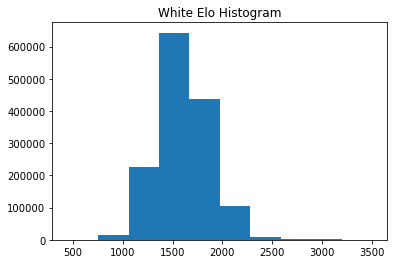

In [46]:
plt.title('White Elo Histogram')
plt.hist(white_elos)

(array([4.66000e+02, 2.09330e+04, 2.61600e+05, 6.45120e+05, 4.07159e+05,
        9.21220e+04, 8.43600e+03, 3.02300e+03, 9.19000e+02, 1.67000e+02]),
 array([ 482. ,  783.8, 1085.6, 1387.4, 1689.2, 1991. , 2292.8, 2594.6,
        2896.4, 3198.2, 3500. ]),
 <BarContainer object of 10 artists>)

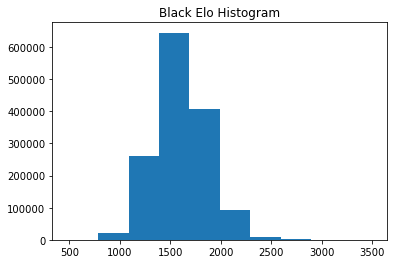

In [47]:
plt.title('Black Elo Histogram')
plt.hist(black_elos)

In [48]:
white_ratings, counts = np.unique(white_elos, return_counts = True)
black_ratings, counts = np.unique(black_elos, return_counts = True)

In [49]:
white_min = np.min(white_elos); white_max = np.max(white_elos)
black_min = np.min(black_elos); black_max = np.max(black_elos)

print(f"For white, min = {white_min}, max = {white_max}")
print(f"For black, min = {black_min}, max = {black_max}")

# Bounds should be the 'loose' one. Might want to cut down in case there's no matchups
lb = min(white_min, black_min); ub = max(white_max, black_max)
print(f"Bins range {lb} - {ub}")

For white, min = 447, max = 3500
For black, min = 482, max = 3500
Bins range 447 - 3500


## Creating the payoffs

### Method 1: Sample uniformly n-bins from the range above, and average the win rate. Win counts for +1, loss -1, draw 0

In [50]:
def create_bins(lower_bound, upper_bound, n):
    width = (upper_bound - lower_bound) / n
    
    ub = lower_bound + width; lb = lower_bound; bins = [(lb, ub)]
    for _ in range(n-1):
        lb += width; ub += width; bins.append((lb, ub))
    
    return bins

def within(bin_range, num):
    return num >= bin_range[0] and num < bin_range[1]

In [55]:
payoff = openPickle('Data/FICS/2019/ChessPayoff12 1500')
marker = openPickle('Data/FICS/2019/ChessMarkers12 1500')

In [56]:
print(markers[500, 501])
print(payoff[500, 501])

1.0
-0.3708791208791209


In [57]:
p1lb = 1483.3333; p1ub = 1484.8
p2lb = 1484.8; p2ub = 1486.26666

In [59]:
sieve_w = (df['white_elo'] < p1ub) & (df['white_elo'] > p1lb)
sieve_b = (df['black_elo'] < p2ub) & (df['black_elo'] > p2lb)
sieve_tot = sieve_w & sieve_b
m1 = np.mean(df[sieve_tot]['result'])
print(m1)

-0.38461538461538464


In [60]:
sieve_w = (df['black_elo'] < p1ub) & (df['black_elo'] > p1lb)
sieve_b = (df['white_elo'] < p2ub) & (df['white_elo'] > p2lb)
sieve_tot = sieve_w & sieve_b
m2 = np.mean(df[sieve_tot]['result'])
print(m2)

0.35714285714285715


In [61]:
print((m1 - m2)/2)

-0.3708791208791209


In [14]:
# Check if data contains lower ratings beating greater ratings
sieve_greater = (df['white_elo'] <= df['black_elo']) & (df['result'] >= 0)
df[sieve_greater]

,game_id,type,result,white_player,black_player,white_elo,black_elo
Index,,,,,,,
1,WagNiFfQ,Blitz,0,batyko,ahli_blunder,1826,1826
20,AAYKnWvt,Bullet,1,KingofKings7,alico1903,2046,2127
25,7da3nkeh,Bullet,1,hshisug,Vperezgm,1887,1924
26,M0Sl5CVI,Rapid,1,RRSR,jvmaximus,1903,1930
38,EuGDHldp,Bullet,1,super-code_ru,Misilleme,800,872
...,...,...,...,...,...,...,...
15961,h8VdqGR9,Bullet,1,AUSTIN_PRINCE,kligs,1447,1461
15962,doApPb6F,Blitz,1,zx14,KadrinEfe,1297,1308
15965,PKRUE0x0,Rapid,1,panscrub5,vezir_mat,1672,1672


In [15]:
# Check if data contains lower ratings beating greater ratings
sieve_greater = (df['black_elo'] <= df['white_elo']) & (df['result'] <= 0)
df[sieve_greater]

,game_id,type,result,white_player,black_player,white_elo,black_elo
Index,,,,,,,
0,mAEz2AcC,Rapid,-1,AliKhaled,ifospor,1702,1628
1,WagNiFfQ,Blitz,0,batyko,ahli_blunder,1826,1826
8,Tr8HhqHt,Blitz,-1,BMWX5,nistvana83,1941,1894
9,53OXpsTy,Bullet,-1,Vperezgm,Telesforus,1935,1921
10,fHwNFnEm,Blitz,-1,ahhatip,inalcik,1133,944
...,...,...,...,...,...,...,...
15950,Bc0MxCBM,Bullet,-1,anton1dalnikovich,Pravin171,1409,1396
15955,3dslmEH7,Blitz,-1,forrest92,Veter-Peremen,1863,1837
15963,vuDze9mH,Blitz,-1,Stock2020,Pavlodar_pvl,2165,2165


In [16]:
wlb, wub = (1829, 1832); blb, bub = (2001, 2003)

In [17]:
sieve_w = (df['white_elo'] < wub) & (df['white_elo'] > wlb)
df_sieve_w = df[sieve_w]
df_sieve_w['black_elo'].unique()

array([1792, 1841, 1983, 1805, 1925, 1763, 1751, 1778, 1872, 1721, 1756,
       1881, 1620, 1724, 1842, 2104, 1704, 1829, 1830, 1803, 1781, 1686,
       1557, 1573, 1546, 2013, 1959, 1860, 1806, 1956, 1862, 1657, 1764,
       2078, 1838, 1749, 1865, 1766, 1699, 1583, 1691, 1807, 1825, 1740,
       1797, 1750, 1722, 1934, 2012, 2034, 1891, 1843, 1637, 1826, 1905,
       1820, 1676, 1856, 1895, 1747, 1606, 1898, 1782, 1965, 1730, 1821,
       1818, 1684, 2056, 1801, 2004, 1789, 1998, 1920, 2207, 1811, 2015,
       1668, 1828, 1526, 1773, 1834, 1744, 1732, 2049, 2062, 1835, 2046,
       1688, 1927, 2020, 1815, 1709, 1824, 1919, 1693, 1772, 1816, 1975,
       1878, 1879, 1485, 1893, 1753, 1864, 1804, 1532, 1587, 1836, 1802,
       1888, 1664, 1913, 1831, 1736, 1882, 1832, 2080, 1787, 1798, 1729,
       1850, 1977, 1746, 1989, 1840, 1450, 1775, 1774, 1972, 1997, 1706,
       2433, 1790, 2018, 1745, 2447, 1930, 2146, 1839, 1886, 1757, 1851,
       1896, 1921, 1786, 1917, 1863, 2245, 1735, 18

In [80]:
# Functions
def create_payoff(n, bin_lb, bin_ub):
    # Construct payoff template and bins
    # Also returns marker array, to indicate whether one missing, both missing, or none missing
    bins = np.array(create_bins(bin_lb, bin_ub, n))
    payoff = np.ones((n, n)) * -8; np.fill_diagonal(payoff, 0)
    
    # Marker matrix to indicate missing data. 1 for both present, -1 for p1 white, -2 for p1 black, -3 for both series
    mat = np.zeros((n, n))
    
    for i in tqdm(range(len(bins))):
        for j in range(len(bins)):
           # These are actually p1 and p2 ratings. We want to find where this p1 rating is white vs p2 black and
            # then vice versa
            p1_bin_lb, p1_bin_ub = bins[i]
            p2_bin_lb, p2_bin_ub = bins[j] 
            
            # Mid-bin rating to predict if missing
            p1_rating = (p1_bin_ub + p1_bin_lb) / 2
            p2_rating = (p2_bin_ub + p2_bin_lb) / 2
            
            if p1_bin_lb >= p2_bin_lb:
                continue
            else:
                # Sieve off data
                p1_white = (df['white_elo'] < p1_bin_ub) & (df['white_elo'] >= p1_bin_lb)
                p2_white = (df['white_elo'] < p2_bin_ub) & (df['white_elo'] >= p2_bin_lb)

                p1_black = (df['black_elo'] < p1_bin_ub) & (df['black_elo'] >= p1_bin_lb)
                p2_black = (df['black_elo'] < p2_bin_ub) & (df['black_elo'] >= p2_bin_lb)

                # Count data available
                p1_white_counts = np.sum(p1_white); p1_black_counts = np.sum(p1_black)
                p2_white_counts = np.sum(p2_white); p2_black_counts = np.sum(p2_black)

                # bool_ser1 = p1 white and p2 black; bool_ser2 = p1 black and p2 white
                bool_ser1 = p1_white & p2_black; bool_ser2 = p1_black & p2_white
                ser1_count = np.sum(bool_ser1); ser2_count = np.sum(bool_ser2)

                if ser1_count != 0 and ser2_count != 0:
                    # Both matchups exist in data
                    # To get average, must put a - b, since if black wins, result is -1. Payoff matrix
                    # is wrt to player 1
                    value = (np.mean(df[bool_ser1]['result']) - np.mean(df[bool_ser2]['result'])) / 2
                    payoff[i,j] = value
                    payoff[j,i] = -value
                    mat[i,j] = 1; mat[j,i] = 1
                else:
                    if ser1_count !=0 and ser2_count == 0:
                        # i.e. series 2 matchup don't exist. Hence series 1 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 2 missing")
                        ser1_rate = np.mean(df[bool_ser1]['result'])

                        # Predict series 2 with elo. This don't care who is white/black
                        # NOTE: win probability is probability of player 1 winning, yielding a reward of +1
                        # To find expected score, must multiply probability with score
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser2_rate = win_prob * 1 + (1 - win_prob) * -1
                
                        value = (ser1_rate + ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -2
                        mat[j,i] = -2

                    if ser1_count == 0 and ser2_count != 0:
                        # i.e. series 1 matchup don't exist. Hence series 2 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 1 missing")
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser1_rate = win_prob * 1 + (1 - win_prob) * -1
                        ser2_rate = np.mean(df[bool_ser2]['result'])
                        value = (ser1_rate - ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -1; mat[j,i] = -1

                    if ser1_count == 0 and ser2_count == 0:
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, both missing")
                        # i.e. both are missing, predict using elo
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        value = win_prob * 1 + (1 - win_prob) * (-1)
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -3; mat[j,i] = -3
                        
    return payoff, mat


def create_payoff_2(white_bins, black_bins):
    # Construct payoff template and bins
    # Also returns marker array, to indicate whether one missing, both missing, or none missing
    n_row = len(white_bins); n_col = len(black_bins)
    payoff = np.ones((n_row, n_col)) * -8; np.fill_diagonal(payoff, 0)
    
    # Marker matrix to indicate missing data. 1 for both present, -1 for p1 white, -2 for p1 black, -3 for both series
    mat = np.zeros((n_row, n_col))
    
    for i in tqdm(range(n_row)):
        for j in range(range(n_col)):
           # These are actually p1 and p2 ratings. We want to find where this p1 rating is white vs p2 black and
            # then vice versa
            p1_bin_lb, p1_bin_ub = white_bins[i]
            p2_bin_lb, p2_bin_ub = black_bins[j]
            
            # Mid-bin rating to predict if missing
            p1_rating = (p1_bin_ub + p1_bin_lb) / 2
            p2_rating = (p2_bin_ub + p2_bin_lb) / 2
            
            if p1_bin_lb >= p2_bin_lb:
                continue
            else:
                # Sieve off data
                p1_white = (df['white_elo'] < p1_bin_ub) & (df['white_elo'] >= p1_bin_lb)
                p2_white = (df['white_elo'] < p2_bin_ub) & (df['white_elo'] >= p2_bin_lb)

                p1_black = (df['black_elo'] < p1_bin_ub) & (df['black_elo'] >= p1_bin_lb)
                p2_black = (df['black_elo'] < p2_bin_ub) & (df['black_elo'] >= p2_bin_lb)

                # Count data available
                p1_white_counts = np.sum(p1_white); p1_black_counts = np.sum(p1_black)
                p2_white_counts = np.sum(p2_white); p2_black_counts = np.sum(p2_black)

                # bool_ser1 = p1 white and p2 black; bool_ser2 = p1 black and p2 white
                bool_ser1 = p1_white & p2_black; bool_ser2 = p1_black & p2_white
                ser1_count = np.sum(bool_ser1); ser2_count = np.sum(bool_ser2)

                if ser1_count != 0 and ser2_count != 0:
                    # Both matchups exist in data
                    # To get average, must put a - b, since if black wins, result is -1. Payoff matrix
                    # is wrt to player 1
                    value = (np.mean(df[bool_ser1]['result']) - np.mean(df[bool_ser2]['result'])) / 2
                    payoff[i,j] = value
                    payoff[j,i] = -value
                    mat[i,j] = 1; mat[j,i] = 1
                else:
                    if ser1_count !=0 and ser2_count == 0:
                        # i.e. series 2 matchup don't exist. Hence series 1 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 2 missing")
                        ser1_rate = np.mean(df[bool_ser1]['result'])

                        # Predict series 2 with elo. This don't care who is white/black
                        # NOTE: win probability is probability of player 1 winning, yielding a reward of +1
                        # To find expected score, must multiply probability with score
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser2_rate = win_prob * 1 + (1 - win_prob) * -1
                
                        value = (ser1_rate + ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -2
                        mat[j,i] = -2

                    if ser1_count == 0 and ser2_count != 0:
                        # i.e. series 1 matchup don't exist. Hence series 2 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 1 missing")
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser1_rate = win_prob * 1 + (1 - win_prob) * -1
                        ser2_rate = np.mean(df[bool_ser2]['result'])
                        value = (ser1_rate - ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -1; mat[j,i] = -1

                    if ser1_count == 0 and ser2_count == 0:
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, both missing")
                        # i.e. both are missing, predict using elo
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        value = win_prob * 1 + (1 - win_prob) * (-1)
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -3; mat[j,i] = -3
                        
    return payoff, mat
            
class NashCluster():
    
    def __init__(self, strat_payoffs, ori_idx, pvect):
        self.size = strat_payoffs.shape[0]
        self.payoffs = strat_payoffs
        self.strat_idx = ori_idx
        self.probability = pvect
        
    def computeRPS(self):
        return None
    
def solve_MaxEnt_NE(payoff, verbose = False, eps = 1e-5, zero_tol = 1e-6, iters = 500, cycle = 5):
    
    init_val = np.random.uniform(size = payoff.shape[0])
    init_val = init_val / np.sum(init_val)
    
    p = cp.Variable(payoff.shape[0], value = init_val)
    constraints = [payoff @ p <= 0, cp.sum(p) == 1, p >= 0]
    objective = cp.sum(cp.entr(p))
    prob = cp.Problem(cp.Maximize(objective), constraints)
    
    try:
      cycle_count = 0; done = False
      while cycle_count < cycle and done is False:
        prob.solve(verbose = verbose, solver = cp.MOSEK, warm_start = True)
        p_vect = p.value * (p.value > zero_tol)
        diff = payoff @ p_vect.reshape(-1, 1)
#         print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
        done = True if np.sum(diff >= eps) == 0 else False
        cycle_count += 1
    except cp.SolverError:
      print("MOSEK FAILED?")
      try:
        # Try ECOS_BB first
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = 1000, solver = cp.ECOS_BB, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
#           print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
      except cp.SolverError:
        print("ECOS_BB FAILED")
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = iters, solver = cp.SCS, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
#           print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
  
    # Clean - small values
    p_vect = p_vect * (p_vect > zero_tol)
    return p_vect, np.sum(diff>=eps)
    
def Nash_Clustering(payoff, marker, algo = "cvx", eps = 1e-4, zero_tol = 1e-8):
    n_strat = payoff.shape[0]; counter = 0;

    # This is the remaining payoff and the remaining strategy indexes
    curr_payoff = payoff; curr_remaining = np.arange(n_strat); curr_marker = marker
    nash_clusters = []; unsolved_cases = []; marker_instances = []

    while n_strat > 1: # if only 1 strategy remaining, this itself is the nash cluster
        print(f"Iteration {counter}")

        # # Compute the NE supports. Lemke Howson seems the fastest
        # game = nash.Game(curr_payoff + np.eye(curr_payoff.shape[0]) * 1e-10)
        # if algo == "Lemke":
        #     nash_eqs = game.lemke_howson_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        # if algo == 'Support': # slow because enumerates all possible NE supports
        #     nash_eqs = game.support_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        # if algo == 'Vertex':
        #     nash_eqs = game.vertex_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        if algo == 'cvx': # solve using cvxpy, seems to be the only one working for now
            nash_eq, diff = solve_MaxEnt_NE(curr_payoff, eps =1e-4, zero_tol = zero_tol, iters = int(2e4), cycle = 5)
            print(f"Outside, diff = {diff}")
            p_vect = nash_eq[nash_eq >= zero_tol]
            if diff > -10:
              print("APPENDING UNSOLVED CASE")
#               unsolved_cases.append(curr_payoff)
#               marker_instances.append(curr_marker)

        # Take the supports, exclude them in the next round payoffs
        taken_strat = np.where(nash_eq >= zero_tol)[0]; remaining_strat = np.where(nash_eq < zero_tol)[0]
        
        if len(taken_strat) != len(p_vect):
            print("WTF")
            print(taken_strat, p_vect)
        taken_idx = np.array(list(itertools.product(taken_strat, repeat = 2)))
        remaining_idx = np.array(list(itertools.product(remaining_strat, repeat = 2)))

        strat_payoffs = payoff[taken_idx[:,0], taken_idx[:, 1]].reshape(taken_strat.shape[0], taken_strat.shape[0])
        nash_clusters.append(NashCluster(strat_payoffs, curr_remaining[taken_strat], p_vect))

        # Get the remaining payoff. If statement here to prevent cases when remaining_idx is empty and [:,0] wont work
        if len(remaining_strat) > 0:
          curr_payoff = curr_payoff[remaining_idx[:,0], remaining_idx[:,1]].reshape(remaining_strat.shape[0], remaining_strat.shape[0])
          curr_remaining = curr_remaining[remaining_strat]
          curr_marker = curr_marker[remaining_idx[:,0], remaining_idx[:,1]].reshape(remaining_strat.shape[0], remaining_strat.shape[0])

        n_strat -= strat_payoffs.shape[0]

        counter += 1
        print(f"Strategies left {n_strat}")
        print(f"Payoff remaining size {curr_payoff.shape[0]}") 

    if n_strat == 1:
        nash_clusters.append(NashCluster(curr_payoff, curr_remaining, np.array([1])))

    return nash_clusters, marker_instances, unsolved_cases

def plot_results(nash_clusters, title):
  nc_sizes = []
  for nc in nash_clusters:
      nc_sizes.append(nc.size)

  y_ax = np.linspace(1, 0, len(nc_sizes))
  plt.scatter(nc_sizes, y_ax)
  plt.title(title)
  plt.ylabel('Fraction Beaten')
  plt.xlabel('Cluster Size')

def compute_RPP(nc1, nc2, payoff):
    p_vect1 = np.zeros(payoff.shape[0]); p_vect2 = np.zeros(payoff.shape[0])
    
    p_vect1[nc1.strat_idx] = nc1.probability; p_vect2[nc2.strat_idx] = nc2.probability
    return (p_vect1.reshape(1, -1) @ payoff @ p_vect2.reshape(-1, 1)).item()
    
def generate_RPP_data(nash_clusters, payoff):
    data_tuples_rpp = []; n_nc = len(nash_clusters); data_tuples_rpp_sign = []; rpp_mat = np.zeros((n_nc, n_nc))
    for i, nc_i in enumerate(nash_clusters):
        rpp_sum = 0; rpp_sign_sum = 0
        for j, nc_j in enumerate(nash_clusters):
            if i != j:
                rpp = compute_RPP(nc_i, nc_j, payoff)
                rpp_mat[i,j] = rpp
                rpp_sum += rpp
                rpp_sign_sum += 1 * (rpp >= 0)

        rpp_sum = rpp_sum / n_nc; rpp_sign_sum = rpp_sign_sum / (n_nc - 1)

        data_tuples_rpp.append([nc_i.size, rpp_sum])
        data_tuples_rpp_sign.append([nc_i.size, rpp_sign_sum])

    return np.array(data_tuples_rpp), np.array(data_tuples_rpp_sign), rpp_mat

def generate_RPS_data(payoff):
    signed_payoff = 1 * (payoff > 0)
    strat_winrate = np.mean(payoff > 0, axis = 1)
    adj = signed_payoff @ signed_payoff @ signed_payoff
    
    return np.diag(adj), strat_winrate

def plot_RPS(adj, strat_winrate, title):
    plt.title(title)
    plt.xlabel('RPS Cycles')
    plt.ylabel('Mean Win-Rate')
    plt.scatter(adj, strat_winrate)
    
def plot_nash_clusters_2(sign_rpp, title):
    plt.scatter(sign_rpp[:, 0], sign_rpp[:, 1])
    plt.title(title)
    plt.ylabel('Fraction Beaten (RPP)')
    plt.xlabel('Cluster Size')
    
def plot_nash_clusters_3(sign_rpp, title, seed = 88):
    plt.scatter(sign_rpp[:, 0], sign_rpp[:, 1])
    plt.title(title)
    plt.ylabel('Fraction Beaten (RPP)')
    plt.xlabel('Cluster Size')
    
    # Fit skewed normal
    np.random.seed(seed)
    y_data = sign_rpp[:, 0]; x_data = sign_rpp[:, 1]
    init = np.random.uniform(1, 3, size = (5))
    params = fit_skewed_normal(init, x_data, y_data)
    
    inputs = np.linspace(0, 1, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    plt.plot(outputs, inputs)
    
    return params
    
# Test using scipy.optimize.minimize. Need a function to minimize with signature function(x, *args), where x is a list
# of the parameters to optimize. Syntax: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
def affine_skewed_normal_loss(parameters, xdata, ydata):
    """
    parameters shape is [\mu, \sigma, \alpha, \a, \b]
    """
    mu, sigma, alpha, a, b = parameters
    
    # Compute the loss
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    loss = np.sum((out - ydata) ** 2)
    
    return loss

def affine_skewed_normal_pdf(parameters, xdata):
    mu, sigma, alpha, a, b = parameters
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    return out

def fit_skewed_normal(init, xdata, ydata):
    bnds = [(None, None), (1e-15, None), (None, None), (None, None), (None, None)]
    results = minimize(affine_skewed_normal_loss, init, args = (xdata, ydata), bounds = bnds, tol = 1e-8)
    return results.x

def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

def savePickle(var, name):
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def openPickle(name):
    filename = name+'.pickle'
    with open(filename,'rb') as f:
        var = pickle.load(f)
    return var

In [19]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCS']


### Chess 1000 x 1000

In [ ]:
# Note: 1st saved matrix is from 800 - 2500
# 2nd saved is 800 - 2800
# 3rd saved is 800 - 2650
# 5 saved is 950 - 2700
# 6 saved is 900 - 2750
# 7 saved is 850 - 2750
# 8 saved is 800 - 2750
# 9: 750 - 2800
# 10: 750 - 2850
# 11: 750 - 2900
# 12: 750 - 2950
# 12.2: 750 - 3050
# 12.3: 750 - 3000

In [15]:
title = 'Chess 1500 (2019) FICS'

In [59]:
payoff, markers = create_payoff(1500, 750, 2950)
where_zeros = np.where(np.abs(payoff) <= 1e-7)
payoff[where_zeros[0], where_zeros[1]] = 0

100%|██████████| 1500/1500 [8:39:03<00:00, 20.76s/it]  


In [36]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, markers)

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1499
Payoff remaining size 1499
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1498
Payoff remaining size 1498
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1497
Payoff remaining size 1497
Iteration 3
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1496
Payoff remaining size 1496
Iteration 4
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1491
Payoff remaining size 1491
Iteration 5
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1490
Payoff remaining size 1490
Iteration 6
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1489
Payoff remaining size 1489
Iteration 7
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1487
Payoff remaining si

Strategies left 1314
Payoff remaining size 1314
Iteration 65
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1313
Payoff remaining size 1313
Iteration 66
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1312
Payoff remaining size 1312
Iteration 67
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1302
Payoff remaining size 1302
Iteration 68
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1301
Payoff remaining size 1301
Iteration 69
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1293
Payoff remaining size 1293
Iteration 70
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1292
Payoff remaining size 1292
Iteration 71
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1285
Payoff remaining size 1285
Iteration 72
Cycle count 0, diff = 0
Outside, diff = 0
APPENDIN

Strategies left 719
Payoff remaining size 719
Iteration 130
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 700
Payoff remaining size 700
Iteration 131
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 685
Payoff remaining size 685
Iteration 132
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 669
Payoff remaining size 669
Iteration 133
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 656
Payoff remaining size 656
Iteration 134
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 641
Payoff remaining size 641
Iteration 135
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 627
Payoff remaining size 627
Iteration 136
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 608
Payoff remaining size 608
Iteration 137
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLV

Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 45
Payoff remaining size 45
Iteration 199
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 40
Payoff remaining size 40
Iteration 200
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 39
Payoff remaining size 39
Iteration 201
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 38
Payoff remaining size 38
Iteration 202
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 37
Payoff remaining size 37
Iteration 203
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 36
Payoff remaining size 36
Iteration 204
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 35
Payoff remaining size 35
Iteration 205
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 34
Payoff remaining size 34
Iteration 206
Cycle co

In [29]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)

In [66]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
np.random.seed(8)
init = np.random.uniform(1, 3, size = (5))
print(init)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[2.74685881 2.93708133 2.73838908 2.06171138 1.46545666]
[ 0.32637928  0.41911705  3.45551848 25.88481319  1.72257756]


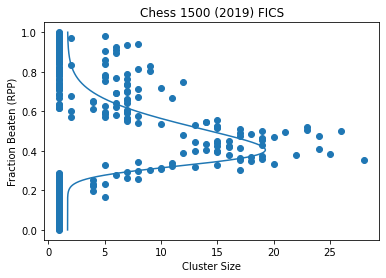

In [32]:
seed = 8
params = plot_nash_clusters_3(rpp_sign_tuples, title, seed)

In [37]:
savePickle(nash_clusters, 'Data/FICS/2019/2019 Nash Clusters 1500 12')

In [35]:
savePickle(params, 'Data/FICS/2019/2019 NC Plot Params 1500 12')
# savePickle(nash_clusters, 'Data/FICS/2019/2019 Nash Clusters 1500 12')
savePickle(rpp_sign_tuples, 'Data/FICS/2019/2019 rpp sign tuples 1500 12')
savePickle(rpp_tuples, 'Data/FICS/2019/2019 rpp tuples 1500 12')
savePickle(rpp_mat, 'Data/FICS/2019/2019 rpp mat 1500 12')

In [65]:
savePickle(payoff, 'Data/FICS/2019/ChessPayoff12 1500')
savePickle(markers, 'Data/FICS/2019/ChessMarkers12 1500')

In [25]:
payoff = openPickle('Data/FICS/2019/ChessPayoff12 1500')
markers = openPickle('Data/FICS/2019/ChessMarkers12 1500')

### Chess 1000 x 1000 Trial 2

In [ ]:
payoff, markers = create_payoff(1000, 800, 2750)
where_zeros = np.where(np.abs(payoff) <= 1e-7)

payoff[where_zeros[0], where_zeros[1]] = 0

 31%|███       | 310/1000 [16:15<31:27,  2.74s/it]

In [26]:
nash_clusters, marker_steps, payoff_steps = Nash_Clustering(payoff, markers, 'cvx')

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1499
Payoff remaining size 1499
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1498
Payoff remaining size 1498
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1497
Payoff remaining size 1497
Iteration 3


KeyboardInterrupt: 

In [98]:
for nc in nash_clusters:
    print(nc.size)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
5
1
5
1
5
1
5
5
4
5
4
1
5
8
7
1
6
5
7
9
8
9
4
11
11
8
6
7
8
7
8
6
10
15
17
9
10
8
18
15
8
19
14
18
14
20
13
15
24
15
19
21
21
14
25
16
21
17
20
12
17
31
17
24
22
19
24
8
15
17
13
12
8
10
10
11
5
1
1
1
1
1
1
1
6
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


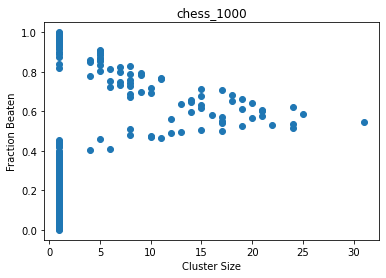

In [99]:
plot_results(nash_clusters, 'chess_1000')

In [100]:
for nc in nash_clusters:
    print(nc.strat_idx)

[999]
[998]
[997]
[996]
[995]
[994]
[993]
[992]
[991]
[990]
[989]
[988]
[987]
[986]
[985]
[913 981 982 983 984]
[805 977 978 979 980]
[976]
[878 972 973 974 975]
[971]
[890 967 968 969 970]
[966]
[914 962 963 964 965]
[796 958 959 960 961]
[814 955 956 957]
[924 951 952 953 954]
[863 948 949 950]
[947]
[877 942 943 945 946]
[910 918 937 938 939 940 941 944]
[885 895 932 933 934 935 936]
[931]
[827 903 927 928 929 930]
[669 922 923 925 926]
[837 896 916 917 919 920 921]
[852 901 905 906 907 908 911 912 915]
[833 883 898 899 900 902 904 909]
[854 873 879 886 889 891 893 894 897]
[820 887 888 892]
[824 825 830 853 871 874 876 880 881 882 884]
[845 847 859 860 862 865 867 868 870 872 875]
[848 855 857 858 861 864 866 869]
[783 800 849 850 851 856]
[810 828 841 842 843 844 846]
[786 802 811 835 836 838 839 840]
[746 812 821 829 831 832 834]
[794 798 815 818 819 822 823 826]
[720 791 792 813 816 817]
[780 784 790 795 797 804 806 807 808 809]
[759 763 767 774 776 778 779 781 785 788 789 793 7

In [101]:
markers[990:, 990:]

array([[ 1., -3., -3., -3., -3., -3., -3., -3., -3., -3.],
       [-3.,  1., -3., -3., -3., -3., -3., -3.,  1., -3.],
       [-3., -3.,  1., -3., -3., -3., -3., -3., -3., -3.],
       [-3., -3., -3.,  1., -3., -3., -3., -3., -3., -3.],
       [-3., -3., -3., -3.,  1., -3., -3., -3., -3., -3.],
       [-3., -3., -3., -3., -3.,  1., -3., -3., -3., -3.],
       [-3., -3., -3., -3., -3., -3.,  1., -3., -3., -3.],
       [-3., -3., -3., -3., -3., -3., -3.,  1., -3., -3.],
       [-3.,  1., -3., -3., -3., -3., -3., -3.,  1., -3.],
       [-3., -3., -3., -3., -3., -3., -3., -3., -3.,  1.]])

In [103]:
np.sum(markers[:70, :70] == -3)

4816

In [106]:
test_bins = create_bins(600, 2800, 1000)
print(test_bins[65:70])
print(test_bins[985:])

[(743.000000000003, 745.200000000003), (745.200000000003, 747.400000000003), (747.400000000003, 749.6000000000031), (749.6000000000031, 751.8000000000031), (751.8000000000031, 754.0000000000032)]
[(2766.9999999999704, 2769.1999999999703), (2769.1999999999703, 2771.39999999997), (2771.39999999997, 2773.59999999997), (2773.59999999997, 2775.7999999999697), (2775.7999999999697, 2777.9999999999695), (2777.9999999999695, 2780.1999999999694), (2780.1999999999694, 2782.399999999969), (2782.399999999969, 2784.599999999969), (2784.599999999969, 2786.799999999969), (2786.799999999969, 2788.9999999999686), (2788.9999999999686, 2791.1999999999684), (2791.1999999999684, 2793.3999999999683), (2793.3999999999683, 2795.599999999968), (2795.599999999968, 2797.799999999968), (2797.799999999968, 2799.9999999999677)]


### Histogram Data Extraction

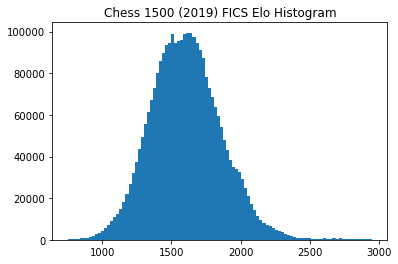

In [62]:
year = 2019
elos = np.concatenate([white_elos, black_elos])
bins = create_bins(750, 2950, 100)
bins = np.array(bins)
hist_bins = np.concatenate([bins[:, 0], [2950]])
plt.title(title + ' Elo Histogram')
out = plt.hist(elos, bins = hist_bins)

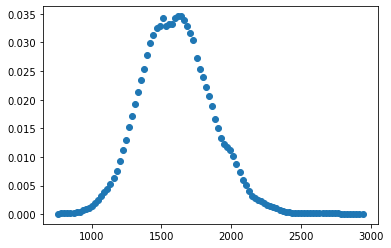

In [63]:
# Data to reproduce plots
counts = out[0]; act_counts = counts
mid_bins = np.mean(bins, axis = 1)
counts = counts / np.sum(counts)
plt.scatter(mid_bins, counts)
set_data = [mid_bins, counts]
count_data = [mid_bins, act_counts]
# savePickle(set_data, 'Data/'+ str(year)+ '/Histogram Data')

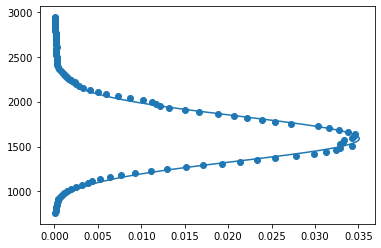

In [64]:
# Fit skewed normal
plt.scatter(counts, mid_bins)
seed = 888
np.random.seed(seed)
y_data = counts; x_data = mid_bins
init = np.random.uniform(0, 0.5, size = (5))
init[0] = 1500; init[1] = 10 * np.sqrt(2)
params = fit_skewed_normal(init, x_data, y_data)

inputs = np.linspace(750, 2950, 1500)
outputs = affine_skewed_normal_pdf(params, inputs)
plt.plot(outputs, inputs)

In [65]:
# Save fitted params so no need to repeat
savePickle(params, 'Data/FICS/'+str(year)+'/Histogram Param')
savePickle(set_data, 'Data/FICS/'+ str(year)+ '/Histogram Data')
savePickle(elos, 'Data/FICS/'+str(year)+'/Histogram Elos')
savePickle(count_data, 'Data/FICS/'+ str(year)+ '/Histogram Count Data')

### Training Data Extraction

In [74]:
# With Uniform

def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

def generate_training_data(payoff, pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300, 350]):
    win_rates_results = dict()

    for pop_size in pop_sizes:
        print(f"Population Size {pop_size}")
        win_rates = []
        strat_strengths = np.mean(payoff > 0, axis = 1)
        ordering_idx = np.argsort(strat_strengths)

        curr_strat_idx = list(ordering_idx[:pop_size])
        win_rates.append(compute_win_rate(curr_strat_idx, payoff))
        n_iters = 2000; it = 0
        converge = False
        while it < n_iters:
            taken_payoff = np.sum(payoff[:, curr_strat_idx], axis = 1)
            viable_strats = np.where(taken_payoff > 0)[0]
            not_in = ~np.isin(viable_strats, curr_strat_idx)
            viable_strats = viable_strats[not_in]
            if len(viable_strats) > 0:
                viable_strengths = strat_strengths[viable_strats]
                sorted_idx = np.argsort(viable_strengths)
                new_strat = viable_strats[sorted_idx[0]]
                curr_strat_idx.append(new_strat)
                curr_strat_idx = curr_strat_idx[1:]
            else:
                if converge == False:
                    converge = True
                    it_conv = it
                    print(f"First Reached Peak at {it_conv}")


            win_rates.append(compute_win_rate(curr_strat_idx, payoff))
            it += 1

        if converge == False:
            print(f"Population size {pop_size} doesn't converge")
            
        win_rates_results[pop_size] = win_rates
    
    return win_rates_results

def plot_training(win_rates_results, title, save = False):
    plt.figure(figsize = (10,8))
    plt.title(title)
    for pop_size in win_rates_results.keys():
        win_rates = win_rates_results[pop_size]
        plt.plot(np.arange(len(win_rates)), win_rates, label = str(pop_size))
        
    plt.xlabel('Iterations')
    plt.ylabel('Mean Win Rate')
    plt.legend(title = 'Population Size')
    
    if save:
        plt.savefig('Training Plots.pdf')

In [68]:
payoff = openPickle('Data/FICS/2019/ChessPayoff12 1500')

In [90]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
training_performances = generate_training_data(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
First Reached Peak at 1508
Population Size 75
First Reached Peak at 1429
Population Size 100
First Reached Peak at 1402
Population Size 150
First Reached Peak at 1351
Population Size 200
First Reached Peak at 1301
Population Size 250
First Reached Peak at 1250
Population Size 300
First Reached Peak at 1200


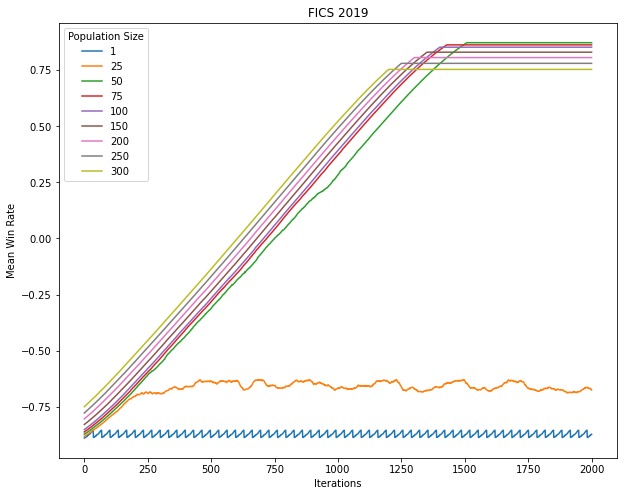

In [91]:
plot_training(training_performances, 'FICS 2019')

In [92]:
savePickle(training_performances, 'FICS 2019 Training Uniform')

In [100]:
# With Nash
def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

def compute_win_rate3(curr_strat_idx, payoff):
    # With Nash
    pop_size = len(curr_strat_idx)
    taken_idx = np.array(list(itertools.product(curr_strat_idx, repeat = 2)))
    taken_payoff = payoff[taken_idx[:, 0], taken_idx[:, 1]].reshape(pop_size, pop_size)
    p_vect, _ = solve_MaxEnt_NE(taken_payoff)
    prob_vect = np.zeros((payoff.shape[0]))
    prob_vect[curr_strat_idx] = p_vect
    return np.mean(prob_vect.reshape(1, -1) @ payoff)

# def compute_win_rate3(curr_strat_idx, payoff, verbose = False):
#     payoff_sieve = payoff[curr_strat_idx, :]
    
#     p = cp.Variable(len(curr_strat_idx))
#     uniform = np.ones(payoff_sieve.shape[1])
#     uniform = uniform / np.sum(uniform)
    
#     constraints = [cp.sum(p) == 1, p >= 0]
#     objective = cp.reshape(p, (1, len(curr_strat_idx))) @ payoff_sieve @ uniform.reshape(-1, 1)
#     prob = cp.Problem(cp.Maximize(objective), constraints)
    
#     prob.solve(verbose = verbose, solver = cp.MOSEK)
    
#     pvect = np.array(p.value)
    
#     return (pvect.reshape(1, -1) @ payoff_sieve @ uniform.reshape(-1, 1)).item()

def generate_training_data3(payoff, pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300, 350]):
    win_rates_results = dict()

    for pop_size in pop_sizes:
        print(f"Population Size {pop_size}")
        win_rates = []
        strat_strengths = np.mean(payoff > 0, axis = 1)
        ordering_idx = np.argsort(strat_strengths)

        curr_strat_idx = list(ordering_idx[:pop_size])
        if pop_size == 1:
            win_rates.append(compute_win_rate(curr_strat_idx, payoff))
        else:
            win_rates.append(compute_win_rate3(curr_strat_idx, payoff))
        n_iters = 2000; it = 0
        converge = False; prev_win_rate = 0
        while it < n_iters:
            taken_payoff = np.sum(payoff[:, curr_strat_idx], axis = 1)
            viable_strats = np.where(taken_payoff > 0)[0]
            not_in = ~np.isin(viable_strats, curr_strat_idx)
            viable_strats = viable_strats[not_in]
            if len(viable_strats) > 0:
                viable_strengths = strat_strengths[viable_strats]
                sorted_idx = np.argsort(viable_strengths)
                new_strat = viable_strats[sorted_idx[0]]
                curr_strat_idx.append(new_strat)
                curr_strat_idx = curr_strat_idx[1:]
            else:
                if converge == False:
                    converge = True
                    it_conv = it
                    print(f"First Reached Peak at {it_conv}")

            if pop_size == 1:
                win_rates.append(compute_win_rate(curr_strat_idx, payoff))
            else:
                if converge:
                    win_rates.append(prev_win_rate)
                else:
                    prev_win_rate = compute_win_rate3(curr_strat_idx, payoff)
                    win_rates.append(prev_win_rate)
                    
            it += 1

        if converge == False:
            print(f"Population size {pop_size} doesn't converge")
            
        win_rates_results[pop_size] = win_rates
    
    return win_rates_results

In [104]:
test = generate_training_data3(payoff, [25, 50, 300])

Population Size 25
Population size 25 doesn't converge
Population Size 50
First Reached Peak at 1508
Population Size 300
First Reached Peak at 1200


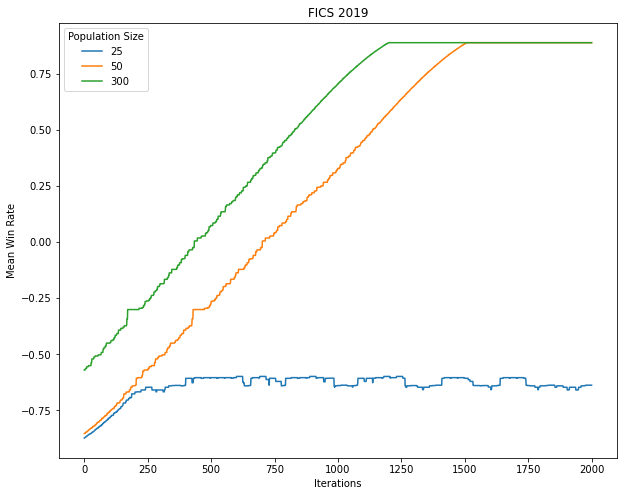

In [105]:
plot_training(test, 'FICS 2019')

In [86]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
training_performances = generate_training_data3(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
First Reached Peak at 1508
Population Size 75
First Reached Peak at 1429
Population Size 100
First Reached Peak at 1402
Population Size 150
First Reached Peak at 1351
Population Size 200
First Reached Peak at 1301
Population Size 250
First Reached Peak at 1250
Population Size 300
First Reached Peak at 1200


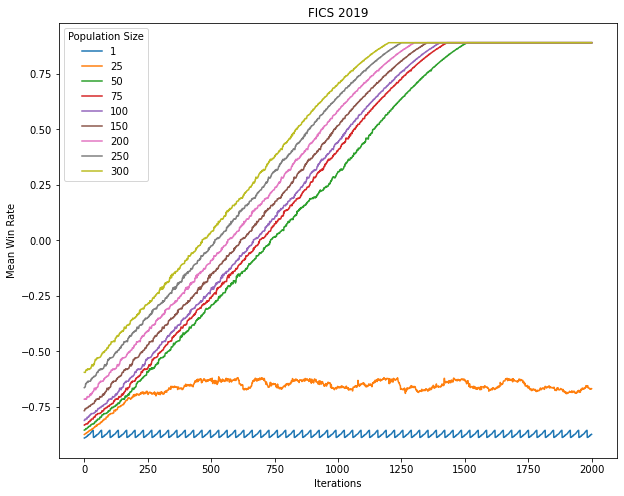

In [87]:
plot_training(training_performances, 'FICS 2019')

In [88]:
savePickle(training_performances, 'FICS 2019 Training Nash')